In [33]:
#beta = infty, RMLE State Evolution algorithm.
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
import time
import math

def seRMLE(rho,lamb,alpha_l,alpha_u,sigma_0,b): #state evolution of RMLE when beta=infty
    k_t = 0.01 #initialized k_t (order parameter)
    chi_t=0.1 #initialized chi_t (order parameter)
    sigma_t2 = 0.1 #initialized sigm_t2 (order parameter)
    eps = 1e-8 #threshold value for unpate order parameters
    parameter_old = np.array([chi_t, k_t, sigma_t2])
    parameter_new = np.array([1, 1, 1])
    iter_se2 = 0 #interation number
    k_collect = [k_t] #collection for k
    sigma2_collect = [sigma_t2] #collection for sigma
    chi_collect = [chi_t] #collection for chi
    rsb_collect = 0
    
    def y_s(p,t): #saddle point method solve for Eq.~(29)
        eps = 1e-12 #epsilon
        y_gst = 1 #initial y^*
        y_pre = 0
        while LA.norm(y_gst-y_pre)>eps:
            y_pre = y_gst
            j = p+np.sqrt(t)*y_pre
            k= -(p+np.sqrt(t)*y_pre)
            y_gst = np.sqrt(t)*(rho*np.exp(j)-(1-rho)*np.exp(k))/(rho*np.exp(j)+(1-rho)*np.exp(k))
        return y_gst

    def F(p, t): #function F Eq.~(30)
        return y_s(p,t)/(np.sqrt(t))

    def T(p, t): #function T Eq.~(31)
        return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

    while LA.norm(parameter_new - parameter_old) > eps and iter_se2<1e2:
        parameter_old = np.array([chi_t, k_t, sigma_t2])
        iter_se2 += 1

        z_values = np.arange(-10, 10, 0.1)
        exp_values = np.exp(-1/2 * z_values**2)
        f_values_1 = F(k_t * sigma_0*b + np.sqrt(k_t**2 * sigma_0*b + sigma_t2*b) * z_values, chi_t*b)
        f_values_2 = F(-k_t * sigma_0*b + np.sqrt(k_t**2 * sigma_0*b + sigma_t2*b) * z_values, chi_t*b)
        t_values_1 = T(k_t * sigma_0*b + np.sqrt(k_t**2 * sigma_0*b + sigma_t2*b) * z_values, chi_t*b)
        t_values_2 = T(-k_t * sigma_0*b + np.sqrt(k_t**2 * sigma_0*b + sigma_t2*b) * z_values, chi_t*b)
        
        sum_t_1 = np.sum(exp_values * t_values_1) / np.sqrt(2 * np.pi) / 10
        sum_t_2 = np.sum(exp_values * t_values_2) / np.sqrt(2 * np.pi) / 10
        
        sum_f_1 = np.sum(exp_values * f_values_1) / np.sqrt(2 * np.pi) / 10
        sum_f_2 = np.sum(exp_values * f_values_2) / np.sqrt(2 * np.pi) / 10
        
        sum_fs_1 = np.sum(exp_values * f_values_1**2) / np.sqrt(2 * np.pi) / 10
        sum_fs_2 = np.sum(exp_values * f_values_2**2) / np.sqrt(2 * np.pi) / 10
        
        chi_new = 1/(1/lamb + b * (alpha_l + alpha_u - alpha_u * (rho*sum_t_1+(1-rho)*sum_t_2))) #SE iter. Eq.~(56a)
        k_new = chi_new * b * (alpha_l + alpha_u * (rho*sum_f_1 -(1-rho)*sum_f_2)) #SE iter. Eq.~(56b)
        sigma_new = chi_new**2 * b * (alpha_l + alpha_u * (rho*sum_fs_1+(1-rho)*sum_fs_2)) #SE iter. Eq.~(56c)
        
        parameter_new = np.array([chi_new, k_new, sigma_new])
        
        k_collect.append(k_new)
        sigma2_collect.append(sigma_new)
        chi_collect.append(chi_new)
        
        k_t = k_new
        sigma_t2 = sigma_new
        chi_t = chi_new
    #replica symmtric breaking...    
    z_values = np.arange(-10, 10, 0.1)
    exp_values = np.exp(-1/2 * z_values**2)
    
    t_values_1 = T(k_collect[-1] * sigma_0*b + np.sqrt(k_collect[-1]**2 * sigma_0*b + sigma2_collect[-1]*b) * z_values, chi_collect[-1]*b)
    t_values_2 = T(-k_collect[-1] * sigma_0*b + np.sqrt(k_collect[-1]**2 * sigma_0*b + sigma2_collect[-1]*b) * z_values, chi_collect[-1]*b)
    
    sum_t_rsb_1 = np.sum(exp_values * t_values_1**2) / np.sqrt(2 * np.pi) / 10
    sum_t_rsb_2 = np.sum(exp_values * t_values_2**2) / np.sqrt(2 * np.pi) / 10

    rsb_collect = alpha_u*b**2*chi_collect[-1]**2*(rho*sum_t_rsb_1+(1-rho)*sum_t_rsb_2)
    return k_collect[-1], sigma2_collect[-1], iter_se2, chi_collect[-1], rsb_collect

In [34]:
#testing...def seRMLE(rho,lamb,alpha_l,alpha_u,sigma_0,b):
se = seRMLE(0.5,0.2,0,0.9,1,3)

In [35]:
se[0]

0.3018467535687932

In [47]:
#phase diagram for seRMLE, alpha_u against SNR(sigma_0^2/sigma^2)
MSE = []
RSB = []
k = []
sig = []
chi = []

#MSE:
def MMSE(k,sig,s0):
    return ((k-1)**2*s0+sig)/s0

for j in np.arange(0,3.01,0.01):
    mse = []
    rsb = []
    k_t = []
    sig_t = []
    chi_t = []
    for b in np.arange(0.001,3.01,0.01):
        se = seRMLE(0.5,0.2,0,j,1,b)#fixed rho=0.5,lamb=0.2,alpha_l=0,sigma_0=1
        k_t.append(se[0])
        sig_t.append(se[1])
        chi_t.append(se[3])
        mse.append(MMSE(se[0],se[1],1)) 
        rsb.append(se[4])
  
    MSE.append(mse)
    RSB.append(rsb)
    k.append(k_t)
    sig.append(sig_t)
    chi.append(chi_t)

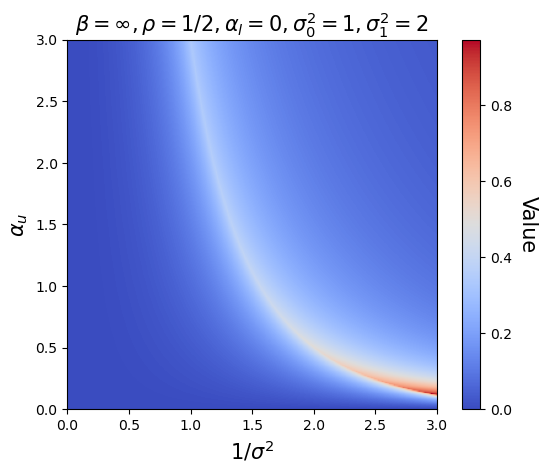

In [56]:
#diff = lu_new_333_n01-lu_new1_333
arr = RSB

# Set the color map to 'coolwarm' (you can choose any other colormap)
cmap = 'coolwarm'

# Create a figure and axis object
fig, ax = plt.subplots()
#fig, ax = plt.subplots(figsize=(6, 4), dpi=100, subplot_kw=dict(aspect='equal'))
# Create a color-coded representation of the array
im = ax.imshow(arr, cmap=cmap, origin='lower', extent=[0, 3, 0, 3])

# Add a colorbar to the figure
cbar = ax.figure.colorbar(im, ax=ax)

# Set the labels for the colorbar
cbar.ax.set_ylabel('Value', rotation=-90, va="bottom",fontsize=15)
#ax.set_xlim([0, 5])
#ax.set_ylim([0, 5])
# Set the x and y axis labels

plt.title(r'$\beta=\infty,\rho=1/2,\alpha_l=0,\sigma_0^2=1,\sigma_1^2=2$',fontsize=15)
#ax.set_xlabel(r'$1/\sigma^2$',fontsize=15)
ax.set_xlabel(r'$1/\sigma^2$',fontsize=15)
ax.set_ylabel(r'$\alpha_u$',fontsize=15)
#plt.grid()
# Show the figure
plt.show()

In [49]:
print(MSE)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [50]:
print(RSB)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [62]:
#phase diagram for seRMLE, alpha_u against SNR(sigma_0^2/sigma^2)
MSE2 = []
RSB2 = []
k2 = []
sig2 = []
chi2 = []

#MSE:
def MMSE(k,sig,s0):
    return ((k-1)**2*s0+sig)/s0

for j in np.arange(0,3.01,0.01):
    mse = []
    rsb = []
    k_t = []
    sig_t = []
    chi_t = []
    for b in np.arange(0.001,3.01,0.01):
        se = seRMLE(0.45,0.2,0,j,1,b)#fixed rho=0.5,lamb=0.2,alpha_l=0,sigma_0=1
        k_t.append(se[0])
        sig_t.append(se[1])
        chi_t.append(se[3])
        mse.append(MMSE(se[0],se[1],1)) 
        rsb.append(se[4])
  
    MSE2.append(mse)
    RSB2.append(rsb)
    k2.append(k_t)
    sig2.append(sig_t)
    chi2.append(chi_t)

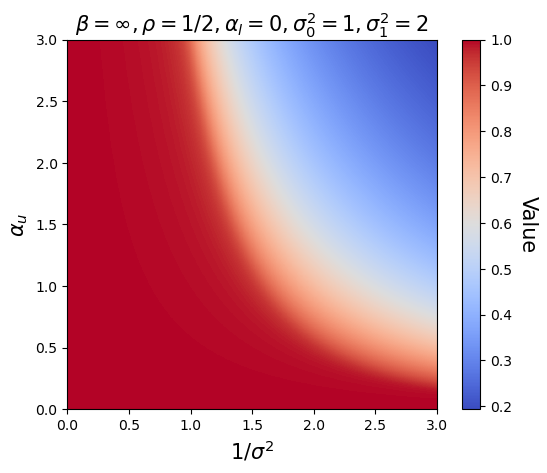

In [63]:
#diff = lu_new_333_n01-lu_new1_333
arr = MSE2

# Set the color map to 'coolwarm' (you can choose any other colormap)
cmap = 'coolwarm'

# Create a figure and axis object
fig, ax = plt.subplots()
#fig, ax = plt.subplots(figsize=(6, 4), dpi=100, subplot_kw=dict(aspect='equal'))
# Create a color-coded representation of the array
im = ax.imshow(arr, cmap=cmap, origin='lower', extent=[0, 3, 0, 3])

# Add a colorbar to the figure
cbar = ax.figure.colorbar(im, ax=ax)

# Set the labels for the colorbar
cbar.ax.set_ylabel('Value', rotation=-90, va="bottom",fontsize=15)
#ax.set_xlim([0, 5])
#ax.set_ylim([0, 5])
# Set the x and y axis labels

plt.title(r'$\beta=\infty,\rho=1/2,\alpha_l=0,\sigma_0^2=1,\sigma_1^2=2$',fontsize=15)
#ax.set_xlabel(r'$1/\sigma^2$',fontsize=15)
ax.set_xlabel(r'$1/\sigma^2$',fontsize=15)
ax.set_ylabel(r'$\alpha_u$',fontsize=15)
#plt.grid()
# Show the figure
plt.show()

In [64]:
#def MMSE(k,sig,s0):#seMMSE_srho(lamb,alpha_l,alpha_u,sigma_0,b) rho=0.5
def seRMLE_srho(lamb,alpha_l,alpha_u,sigma_0,b): #state evolution of RMLE when beta=infty
    k_t = 0.01 #initialized k_t (order parameter)
    chi_t=0.1 #initialized chi_t (order parameter)
    sigma_t2 = 0.1 #initialized sigm_t2 (order parameter)
    eps = 1e-8 #threshold value for unpate order parameters
    parameter_old = np.array([chi_t, k_t, sigma_t2])
    parameter_new = np.array([1, 1, 1])
    iter_se2 = 0 #interation number
    k_collect = [k_t] #collection for k
    sigma2_collect = [sigma_t2] #collection for sigma
    chi_collect = [chi_t] #collection for chi
    rsb_collect = 0
    
    def y_s(p,t): #saddle point method solve for Eq.~(29)
        eps = 1e-12 #epsilon
        y_gst = 1 #initial y^*
        y_pre = 0
        while LA.norm(y_gst-y_pre)>eps:
            y_pre = y_gst
            j = p+np.sqrt(t)*y_pre
            k= -(p+np.sqrt(t)*y_pre)
            y_gst = np.sqrt(t)*np.tanh(p+np.sqrt(t)*y_pre)
        return y_gst

    def F(p, t): #function F Eq.~(30)
        return y_s(p,t)/(np.sqrt(t))

    def T(p, t): #function T Eq.~(31)
        return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

    while LA.norm(parameter_new - parameter_old) > eps and iter_se2<1e2:
        parameter_old = np.array([chi_t, k_t, sigma_t2])
        iter_se2 += 1

        z_values = np.arange(-10, 10, 0.1)
        exp_values = np.exp(-1/2 * z_values**2)
        f_values_1 = F(k_t * sigma_0*b + np.sqrt(k_t**2 * sigma_0*b + sigma_t2*b) * z_values, chi_t*b)
        t_values_1 = T(k_t * sigma_0*b + np.sqrt(k_t**2 * sigma_0*b + sigma_t2*b) * z_values, chi_t*b)
        
        sum_t_1 = np.sum(exp_values * t_values_1) / np.sqrt(2 * np.pi) / 10
    
        sum_f_1 = np.sum(exp_values * f_values_1) / np.sqrt(2 * np.pi) / 10
        
        sum_fs_1 = np.sum(exp_values * f_values_1**2) / np.sqrt(2 * np.pi) / 10

        
        chi_new = 1/(1/lamb + b * (alpha_l + alpha_u - alpha_u * sum_t_1)) #SE iter. Eq.~(56a)
        k_new = chi_new * b * (alpha_l + alpha_u * sum_f_1) #SE iter. Eq.~(56b)
        sigma_new = chi_new**2 * b * (alpha_l + alpha_u * sum_fs_1) #SE iter. Eq.~(56c)
        
        parameter_new = np.array([chi_new, k_new, sigma_new])
        
        k_collect.append(k_new)
        sigma2_collect.append(sigma_new)
        chi_collect.append(chi_new)
        
        k_t = k_new
        sigma_t2 = sigma_new
        chi_t = chi_new
    #replica symmtric breaking...    
    z_values = np.arange(-10, 10, 0.1)
    exp_values = np.exp(-1/2 * z_values**2)
    
    t_values_1 = T(k_collect[-1] * sigma_0*b + np.sqrt(k_collect[-1]**2 * sigma_0*b + sigma2_collect[-1]*b) * z_values, chi_collect[-1]*b)
    
    sum_t_rsb_1 = np.sum(exp_values * t_values_1**2) / np.sqrt(2 * np.pi) / 10

    rsb_collect = alpha_u*b**2*chi_collect[-1]**2*sum_t_rsb_1
    return k_collect[-1], sigma2_collect[-1], iter_se2, chi_collect[-1], rsb_collect

In [65]:
#phase diagram for seRMLE, alpha_u against SNR(sigma_0^2/sigma^2)
MSE3 = []
RSB3 = []
k3 = []
sig3 = []
chi3 = []

#MSE:
def MMSE(k,sig,s0):
    return ((k-1)**2*s0+sig)/s0

for j in np.arange(0,3.01,0.01):
    mse = []
    rsb = []
    k_t = []
    sig_t = []
    chi_t = []
    for b in np.arange(0.001,3.01,0.01):
        se = seRMLE_srho(0.33,0,j,1,b)#fixed rho=0.5,lamb=0.2,alpha_l=0,sigma_0=1
        k_t.append(se[0])
        sig_t.append(se[1])
        chi_t.append(se[3])
        mse.append(MMSE(se[0],se[1],1)) 
        rsb.append(se[4])
  
    MSE3.append(mse)
    RSB3.append(rsb)
    k3.append(k_t)
    sig3.append(sig_t)
    chi3.append(chi_t)

/var/folders/n8/dk5_vvm52nd81xrp_wmhys9h0000gn/T/ipykernel_78334/964336476.py:21: RuntimeWarning: invalid value encountered in sqrt
  j = p+np.sqrt(t)*y_pre
/var/folders/n8/dk5_vvm52nd81xrp_wmhys9h0000gn/T/ipykernel_78334/964336476.py:22: RuntimeWarning: invalid value encountered in sqrt
  k= -(p+np.sqrt(t)*y_pre)
/var/folders/n8/dk5_vvm52nd81xrp_wmhys9h0000gn/T/ipykernel_78334/964336476.py:23: RuntimeWarning: invalid value encountered in sqrt
  y_gst = np.sqrt(t)*np.tanh(p+np.sqrt(t)*y_pre)
/var/folders/n8/dk5_vvm52nd81xrp_wmhys9h0000gn/T/ipykernel_78334/964336476.py:27: RuntimeWarning: invalid value encountered in sqrt
  return y_s(p,t)/(np.sqrt(t))


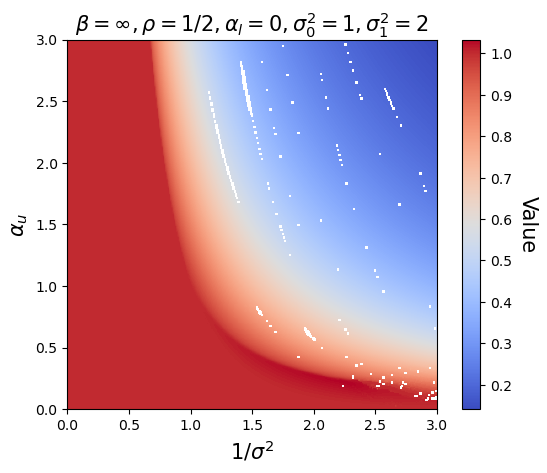

In [66]:
#diff = lu_new_333_n01-lu_new1_333
arr = MSE3

# Set the color map to 'coolwarm' (you can choose any other colormap)
cmap = 'coolwarm'

# Create a figure and axis object
fig, ax = plt.subplots()
#fig, ax = plt.subplots(figsize=(6, 4), dpi=100, subplot_kw=dict(aspect='equal'))
# Create a color-coded representation of the array
im = ax.imshow(arr, cmap=cmap, origin='lower', extent=[0, 3, 0, 3])

# Add a colorbar to the figure
cbar = ax.figure.colorbar(im, ax=ax)

# Set the labels for the colorbar
cbar.ax.set_ylabel('Value', rotation=-90, va="bottom",fontsize=15)
#ax.set_xlim([0, 5])
#ax.set_ylim([0, 5])
# Set the x and y axis labels

plt.title(r'$\beta=\infty,\rho=1/2,\alpha_l=0,\sigma_0^2=1,\sigma_1^2=2$',fontsize=15)
#ax.set_xlabel(r'$1/\sigma^2$',fontsize=15)
ax.set_xlabel(r'$1/\sigma^2$',fontsize=15)
ax.set_ylabel(r'$\alpha_u$',fontsize=15)
#plt.grid()
# Show the figure
plt.show()

In [69]:
#phase diagram for seRMLE, alpha_u against SNR(sigma_0^2/sigma^2)
MSE4 = []
RSB4 = []
k4 = []
sig4 = []
chi4 = []

#MSE:
def MMSE(k,sig,s0):
    return ((k-1)**2*s0+sig)/s0

for j in np.arange(0,3.01,0.01):
    mse = []
    rsb = []
    k_t = []
    sig_t = []
    chi_t = []
    for b in np.arange(0.001,3.01,0.01):
        se = seRMLE_srho(0.25,0,j,1,b)#fixed rho=0.5,lamb=0.2,alpha_l=0,sigma_0=1
        k_t.append(se[0])
        sig_t.append(se[1])
        chi_t.append(se[3])
        mse.append(MMSE(se[0],se[1],1)) 
        rsb.append(se[4])
  
    MSE4.append(mse)
    RSB4.append(rsb)
    k4.append(k_t)
    sig4.append(sig_t)
    chi4.append(chi_t)

/var/folders/n8/dk5_vvm52nd81xrp_wmhys9h0000gn/T/ipykernel_78334/964336476.py:21: RuntimeWarning: invalid value encountered in sqrt
  j = p+np.sqrt(t)*y_pre
/var/folders/n8/dk5_vvm52nd81xrp_wmhys9h0000gn/T/ipykernel_78334/964336476.py:22: RuntimeWarning: invalid value encountered in sqrt
  k= -(p+np.sqrt(t)*y_pre)
/var/folders/n8/dk5_vvm52nd81xrp_wmhys9h0000gn/T/ipykernel_78334/964336476.py:23: RuntimeWarning: invalid value encountered in sqrt
  y_gst = np.sqrt(t)*np.tanh(p+np.sqrt(t)*y_pre)
/var/folders/n8/dk5_vvm52nd81xrp_wmhys9h0000gn/T/ipykernel_78334/964336476.py:27: RuntimeWarning: invalid value encountered in sqrt
  return y_s(p,t)/(np.sqrt(t))


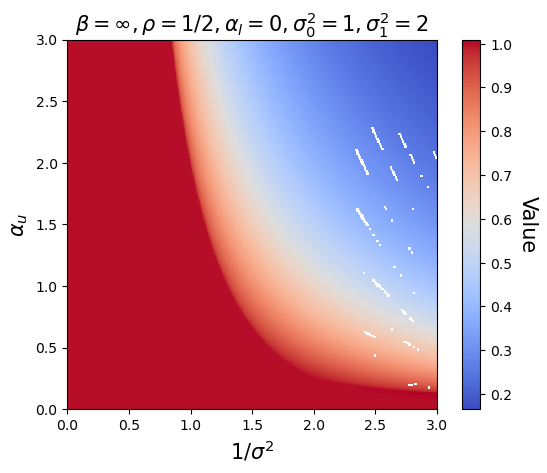

In [72]:
#diff = lu_new_333_n01-lu_new1_333
arr = MSE4

# Set the color map to 'coolwarm' (you can choose any other colormap)
cmap = 'coolwarm'

# Create a figure and axis object
fig, ax = plt.subplots()
#fig, ax = plt.subplots(figsize=(6, 4), dpi=100, subplot_kw=dict(aspect='equal'))
# Create a color-coded representation of the array
im = ax.imshow(arr, cmap=cmap, origin='lower', extent=[0, 3, 0, 3])

# Add a colorbar to the figure
cbar = ax.figure.colorbar(im, ax=ax)

# Set the labels for the colorbar
cbar.ax.set_ylabel('Value', rotation=-90, va="bottom",fontsize=15)
#ax.set_xlim([0, 5])
#ax.set_ylim([0, 5])
# Set the x and y axis labels

plt.title(r'$\beta=\infty,\rho=1/2,\alpha_l=0,\sigma_0^2=1,\sigma_1^2=2$',fontsize=15)
#ax.set_xlabel(r'$1/\sigma^2$',fontsize=15)
ax.set_xlabel(r'$1/\sigma^2$',fontsize=15)
ax.set_ylabel(r'$\alpha_u$',fontsize=15)
#plt.grid()
# Show the figure
plt.show()

In [73]:
#def MMSE(k,sig,s0):#seMMSE_srho(lamb,alpha_l,alpha_u,sigma_0,b) rho=0.5 fixed chi
def seRMLE_srho_ChiFix(chi,lamb,alpha_l,alpha_u,sigma_0,b): #state evolution of RMLE when beta=infty
    k_t = 0.01 #initialized k_t (order parameter)
    #chi_t=0.1 #initialized chi_t (order parameter)
    sigma_t2 = 0.1 #initialized sigm_t2 (order parameter)
    eps = 1e-8 #threshold value for unpate order parameters
    parameter_old = np.array([k_t, sigma_t2])
    parameter_new = np.array([1, 1])
    iter_se2 = 0 #interation number
    k_collect = [k_t] #collection for k
    sigma2_collect = [sigma_t2] #collection for sigma
    #chi_collect = [chi_t] #collection for chi
    rsb_collect = 0
    
    def y_s(p,t): #saddle point method solve for Eq.~(29)
        eps = 1e-12 #epsilon
        y_gst = 1 #initial y^*
        y_pre = 0
        while LA.norm(y_gst-y_pre)>eps:
            y_pre = y_gst
            y_gst = np.sqrt(t)*np.tanh(p+np.sqrt(t)*y_pre)
        return y_gst

    def F(p, t): #function F Eq.~(30)
        return y_s(p,t)/(np.sqrt(t))

    def T(p, t): #function T Eq.~(31)
        return (1-F(p,t)**2)/(1-t*(1-F(p,t)**2))

    while LA.norm(parameter_new - parameter_old) > eps and iter_se2<1e2:
        parameter_old = np.array([k_t, sigma_t2])
        iter_se2 += 1

        z_values = np.arange(-10, 10, 0.1)
        exp_values = np.exp(-1/2 * z_values**2)
        f_values_1 = F(k_t * sigma_0*b + np.sqrt(k_t**2 * sigma_0*b + sigma_t2*b) * z_values, chi*b)
    
        sum_f_1 = np.sum(exp_values * f_values_1) / np.sqrt(2 * np.pi) / 10
        
        sum_fs_1 = np.sum(exp_values * f_values_1**2) / np.sqrt(2 * np.pi) / 10
        
        k_new = chi * b * (alpha_l + alpha_u * sum_f_1) #SE iter. Eq.~(56b)
        sigma_new = chi**2 * b * (alpha_l + alpha_u * sum_fs_1) #SE iter. Eq.~(56c)
        
        parameter_new = np.array([k_new, sigma_new])
        
        k_collect.append(k_new)
        sigma2_collect.append(sigma_new)
        #chi_collect.append(chi_new)
        
        k_t = k_new
        sigma_t2 = sigma_new
        #chi_t = chi_new
    #replica symmtric breaking...    
    z_values = np.arange(-10, 10, 0.1)
    exp_values = np.exp(-1/2 * z_values**2)
    
    t_values_1 = T(k_collect[-1] * sigma_0*b + np.sqrt(k_collect[-1]**2 * sigma_0*b + sigma2_collect[-1]*b) * z_values, chi*b)
    
    sum_t_rsb_1 = np.sum(exp_values * t_values_1**2) / np.sqrt(2 * np.pi) / 10

    rsb_collect = alpha_u*b**2*chi**2*sum_t_rsb_1
    return k_collect[-1], sigma2_collect[-1], iter_se2, rsb_collect

In [ ]:
#phase diagram for seRMLE, alpha_u against SNR(sigma_0^2/sigma^2)
#seRMLE_srho_ChiFix(chi,lamb,alpha_l,alpha_u,sigma_0,b):
MSE5 = []
RSB5 = []
k5 = []
sig5 = []
#chi5 = []

#MSE:
def MMSE(k,sig,s0):
    return ((k-1)**2*s0+sig)/s0

for j in np.arange(0,3.001,0.001):
    mse = []
    rsb = []
    k_t = []
    sig_t = []
    #chi_t = []
    for c in np.arange(0.001,1.001,0.001):
        se = seRMLE_srho_ChiFix(c,1,0,j,1,1)#fixed rho=0.5,lamb=0.2,alpha_l=0,sigma_0=1
        k_t.append(se[0])
        sig_t.append(se[1])
        #chi_t.append(se[3])
        mse.append(MMSE(se[0],se[1],1)) 
        rsb.append(se[3])
  
    MSE5.append(mse)
    RSB5.append(rsb)
    k5.append(k_t)
    sig5.append(sig_t)
    #chi5.append(chi_t)